In [ ]:
import tensorflow as tf
print(tf.__version__)

# Tutorial #4: Saving and loading models

## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [ ]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [ ]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [ ]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [ ]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

In [ ]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

#### Train model with checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, frequency='epoch', save_weights_only=True, verbose=1)

In [ ]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x=x_train, y=y_train, epochs=3, callbacks=[checkpoint])

In [ ]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

In [ ]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

#### Create new model, load weights

In [ ]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

In [ ]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

#### Clear directory

In [ ]:
! rm -r model_checkpoints

## Explanation of saved files

Previously, you experimented with the ModelCheckpoint callback, which can be used to save model weights during training. You looked at the saved files using the `! ls` command. The saved files were the following:

```
-rw-r--r--  1 aph416  staff    87B  2 Nov 17:04 checkpoint
-rw-r--r--  1 aph416  staff   2.0K  2 Nov 17:04 checkpoint.index
-rw-r--r--  1 aph416  staff   174K  2 Nov 17:04 checkpoint.data-00000-of-00001
```

So, what are each of these files?

#### `checkpoint`

This file is by far the smallest, at only 87 bytes. It's actually so small that we can just look at it directly. It's a human readable file with the following text:

```
model_checkpoint_path: "checkpoint"
all_model_checkpoint_paths: "checkpoint"
```

This is metadata that indicates where the actual model data is stored.

#### `checkpoint`

This file is by far the smallest, at only 87 bytes. It's actually so small that we can just look at it directly. It's a human readable file with the following text:

```
model_checkpoint_path: "checkpoint"
all_model_checkpoint_paths: "checkpoint"
```

This is metadata that indicates where the actual model data is stored.

#### `checkpoint.index`

This file tells TensorFlow which weights are stored where. When running models on distributed systems, there may be different *shards*, meaning the full model may have to be recomposed from multiple sources. In the last notebook, you created a single model on a single machine, so there is only one *shard* and all weights are stored in the same place.

#### `checkpoint.data-00000-of-00001`

This file contains the actual weights from the model. It is by far the largest of the 3 files. Recall that the model you trained had around 14000 parameters, meaning this file is roughly 12 bytes per saved weight.

### Further reading and resources

* https://www.tensorflow.org/tutorials/keras/save_and_load#what_are_these_files

## Model saving criteria

#### Create more customised checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_5000_path = 'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path, save_weights_only=True, save_freq=5000, verbose=1)

In [ ]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train, y=y_train, epochs=3, validation_data=(x_test, y_test), batch_size=10, callbacks=[checkpoint_5000])

In [ ]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints_5000

#### Work with model saving criteria

In [ ]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [ ]:
# Create a new instance of untrained model

model = get_new_model()

In [ ]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, 
                                  save_weights_only=True, 
                                  save_freq='epoch', 
                                  monitor='val_accuracy', 
                                  save_best_only=True,
                                  verbose=1)

In [ ]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=50, 
                    validation_data=(x_test, y_test),
                    batch_size=10,
                    callbacks=[checkpoint_best],
                    verbose=0)

In [ ]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [ ]:
# Inspect the checkpoint directory

! ls -lh model_checkpoints_best

In [ ]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

#### Clear directory

In [ ]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequency='epoch',
                             verbose=1)

In [ ]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          callbacks=[checkpoint])

#### Inspect what the checkpoint has created

In [ ]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

In [ ]:
# Enter variables directory

! ls -lh model_checkpoints/variables

In [ ]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

#### Create new model from scratch

In [ ]:
# Delete model

del model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

#### Use the .h5 format to save model

In [ ]:
# Save the model in .h5 format

model.save('my_model.h5')

In [ ]:
# Inspect .h5 file

! ls -lh my_model.h5

In [ ]:
# Delete model

del model

In [ ]:
# Reload model from scratch

model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

#### Clear directory

In [ ]:
! rm -r model_checkpoints
! rm my_model.h5

## Saving model architecture only

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import json
import numpy as np

### Accessing a model's configuration

A model's *configuration* refers to its architecture. TensorFlow has a convenient way to retrieve a model's architecture as a dictionary. We start by creating a simple fully connected feedforward neural network with 1 hidden layer.

In [ ]:
# Build the model

model = Sequential([
    Dense(units=32, input_shape=(32, 32, 3), activation='relu', name='dense_1'),
    Dense(units=10, activation='softmax', name='dense_2')
])

A TensorFlow model has an inbuilt method `get_config` which returns the model's architecture as a dictionary:

In [ ]:
# Get the model config

config_dict = model.get_config()
print(config_dict)

### Creating a new model from the config
A new TensorFlow model can be created from this config dictionary. This model will have reinitialized weights, which are not the same as the original model.

In [ ]:
# Create a model from the config dictionary

model_same_config = tf.keras.Sequential.from_config(config_dict)

We can check explicitly that the config of both models is the same, but the weights are not: 

In [ ]:
# Check the new model is the same architecture

print('Same config:', 
      model.get_config() == model_same_config.get_config())
print('Same value for first weight matrix:', 
      np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

For models that are not `Sequential` models, use `tf.keras.Model.from_config` instead of `tf.keras.Sequential.from_config`.

### Other file formats: JSON and YAML
It is also possible to obtain a model's config in JSON or YAML formats. This follows the same pattern:

In [ ]:
# Convert the model to JSON

json_string = model.to_json()
print(json_string)

The JSON format can easily be written out and saved as a file:

In [ ]:
# Write out JSON config file

with open('config.json', 'w') as f:
    json.dump(json_string, f)
del json_string

In [ ]:
# Read in JSON config file again

with open('config.json', 'r') as f:
    json_string = json.load(f)

In [ ]:
# Reinitialize the model

model_same_config = tf.keras.models.model_from_json(json_string)

In [ ]:
# Check the new model is the same architecture, but different weights

print('Same config:', 
      model.get_config() == model_same_config.get_config())
print('Same value for first weight matrix:', 
      np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

The YAML format is similar. The details of writing out YAML files, loading them and using them to create a new model are similar as for the JSON files, so we won't show it here.

In [ ]:
# Convert the model to YAML

yaml_string = model.to_yaml()
print(yaml_string)

### Further reading and resources
* https://www.tensorflow.org/guide/keras/save_and_serialize#architecture-only_saving
* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
# Build Keras ResNet50 model

model = ResNet50(weights='imagenet')
model.summary()

#### Import and preprocess 3 sample images

In [105]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('tutorial_data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('tutorial_data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('tutorial_data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [110]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

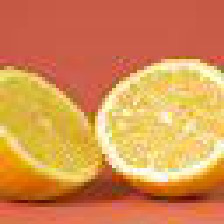

In [106]:
# Display image

lemon_img

In [111]:
# Display top 5 predictions

get_top_5_predictions(lemon_img)

40960/35363 [==================================] - 0s 1us/step


,prediction,probability
1,lemon,0.242908
2,consomme,0.186441
3,eggnog,0.157404
4,face_powder,0.0334387
5,spotlight,0.0315004


##### Image 2: viaduct

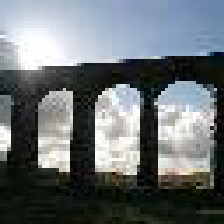

In [107]:
# Display image

viaduct_img

In [112]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.401867
2,viaduct,0.124293
3,prison,0.0984373
4,window_screen,0.0711981
5,fire_screen,0.0182376


##### Image 3: water tower

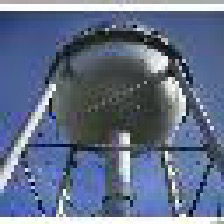

In [109]:
# Display image

water_tower_img

In [113]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.408545
2,planetarium,0.163328
3,ladle,0.12174
4,strainer,0.0272507
5,jigsaw_puzzle,0.0272226


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In [115]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [120]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [117]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("tutorial_data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("tutorial_data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("tutorial_data/water_tower.jpg", target_size=(160, 160))

In [118]:
# Read in categories text file

with open('tutorial_data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [119]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

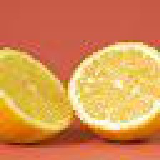

In [121]:
lemon_img

In [122]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,sandal
3,tray
4,brassiere
5,Petri dish


##### Image 2: viaduct

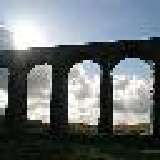

In [123]:
viaduct_img

In [124]:
get_top_5_predictions(viaduct_img)

,prediction
1,viaduct
2,pier
3,megalith
4,monastery
5,triumphal arch


##### Image 3: water tower

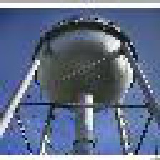

In [125]:
water_tower_img

In [126]:
get_top_5_predictions(water_tower_img)

,prediction
1,water tower
2,solar dish
3,submarine
4,aircraft carrier
5,castle
